In [57]:
## Create a Spark Session
import os, sys

import os, subprocess
from pyspark.sql import SparkSession

# first gotta try auto-detect Java17 on my Mac; then fallback to the know path if
# needed. otherwise my spark wasn't loading data correctly.

try:
    os.environ["JAVA_HOME"] = subprocess.check_output(
        ["/usr/libexec/java_home", "-v", "17"]
    ).decode().strip()
except Exception:
    os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@17/17.0.16/libexec/openjdk.jdk/Contents/Home"

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Efficiency Analysis")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "3g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
print("Spark session ready buddy.")

Spark session ready buddy.


In [59]:
spark.conf.set("spark.sql.shuffle.partitions", "8")

In [61]:
## Download the data for the yellow taxi trips in NYC from Jan-June 2019.

import os
from urllib.request import urlretrieve

# this is the output folder where i'll store the data
project_root = os.path.expanduser("~/Documents/GitHub/MAST30034_Python")
out_dir = os.path.join(project_root, "data", "tlc_data")
os.makedirs(out_dir, exist_ok=True)

YEAR = "2019"
MONTHS = range(1,7) #Jan to June

BASE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"

# for each selected month...
for m in MONTHS:
    mm = f"{m:02d}" # format it as 2 digit (i.e. 01, 02 etc)
    url = f"{BASE}{YEAR}-{mm}.parquet" # make a download link
    dest = os.path.join(out_dir, f"{YEAR}-{mm}.parquet")
    
    # just gotta check if the file exists already before downloading
    if os.path.exists(dest):
        print("Already have " + os.path.basename(dest))
    else:
        print("Downloading " + os.path.basename(dest) + "...")
        urlretrieve(url, dest)

print("Done.")

Already have 2019-01.parquet
Already have 2019-02.parquet
Already have 2019-03.parquet
Already have 2019-04.parquet
Already have 2019-05.parquet
Already have 2019-06.parquet
Done.


In [63]:
## Download the taxi zone lookup (CSV) and shapefile (ZIP). This allows us to map
## the numeric location IDs to actual neighbourhoods in NYC. 
## Will be helpful for geospatial analysis later


import os
from urllib.request import urlretrieve

zones_dir = os.path.join(project_root, "data", "taxi_zones")

# subfolder to keep the taxi zone reference files
os.makedirs("../data/taxi_zones", exist_ok=True)

# heres two reference files provided by TLC
zone_lookup = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
zone_zip    = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"

# loop through the two files above and download (if not already downloaded)
for url in [zone_lookup, zone_zip]:
    name = url.split("/")[-1]                
    dest = "../data/taxi_zones/" + name      # the local path to save into
    if os.path.exists(dest):
        print("Already have " + name)
    else:
        print("Downloading " + name + " ...")
        urlretrieve(url, dest)               # download from URL

print("Zones ready.")

Already have taxi+_zone_lookup.csv
Already have taxi_zones.zip
Zones ready.


In [65]:
## Load all NYC Yellow Taxi trip data (Jan-June 2019) into Spark
## Read only one month first.

from glob import glob
import os

data_dir = os.path.join(project_root, "data", "tlc_data")

# then show what is already on disk
files = sorted(glob(os.path.join(data_dir, "*.parquet")))
print("Found:", [os.path.basename(f) for f in files])

# read the Jan one only just to avoid overload
one_month = os.path.join(data_dir, "2019-01.parquet")
print("Reading:", one_month)

df = spark.read.parquet(one_month)
df.select(
    "tpep_pickup_datetime","tpep_dropoff_datetime","trip_distance","fare_amount"
).show(5, truncate=False)

# just wanna see the columns
df.printSchema()

Found: ['2019-01.parquet', '2019-02.parquet', '2019-03.parquet', '2019-04.parquet', '2019-05.parquet', '2019-06.parquet']
Reading: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/data/tlc_data/2019-01.parquet
+--------------------+---------------------+-------------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|
+--------------------+---------------------+-------------+-----------+
|2019-01-01 00:46:40 |2019-01-01 00:53:20  |1.5          |7.0        |
|2019-01-01 00:59:47 |2019-01-01 01:18:59  |2.6          |14.0       |
|2018-12-21 13:48:30 |2018-12-21 13:52:40  |0.0          |4.5        |
|2018-11-28 15:52:25 |2018-11-28 15:55:45  |0.0          |3.5        |
|2018-11-28 15:56:57 |2018-11-28 15:58:33  |0.0          |52.0       |
+--------------------+---------------------+-------------+-----------+
only showing top 5 rows
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_date

In [67]:
# then can read the remaining columns

paths = [os.path.join(data_dir, f"2019-{mm}.parquet") for mm in ["01","02","03","04","05","06"]]
print("Reading:", [os.path.basename(p) for p in paths if os.path.exists(p)])

df = spark.read.parquet(*[p for p in paths if os.path.exists(p)])
print("Rows:", df.count())

Reading: ['2019-01.parquet', '2019-02.parquet', '2019-03.parquet', '2019-04.parquet', '2019-05.parquet', '2019-06.parquet']
Rows: 44658561


In [13]:
# okay now here im gonna create some efficiency metrics

from pyspark.sql import functions as F
from pyspark import StorageLevel

# duration in minutes (pickup to dropoff) 
df2 = df.withColumn(
    "duration_min",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60.0
)


# basic cleaning, like distance hance to be above 0, fare amounts have to be
# within a reasonable range etc
df2 = (
    df2
    .filter(F.col("trip_distance") > 0)
    .filter(F.col("duration_min") > 0)                 # was trip_duration_min
    .filter(F.col("total_amount").between(0, 500))
)

# some efficiency metrics
df2 = (
    df2
    .withColumn("earnings_per_min", F.col("total_amount") / F.col("duration_min"))
    .withColumn("earnings_per_km",  F.col("total_amount") / (F.col("trip_distance") * 1.60934))
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
    .withColumn("pickup_dow",  F.date_format("tpep_pickup_datetime","E"))
)

# just visually checking if the columns look correct
df2.select("duration_min","earnings_per_min","earnings_per_km").limit(5).show(truncate=False)

print("Approx sample size peek:", df2.limit(100000).count())  # bounded work

+------------------+------------------+------------------+
|duration_min      |earnings_per_min  |earnings_per_km   |
+------------------+------------------+------------------+
|6.666666666666667 |1.4925            |4.121772486443717 |
|19.2              |0.8489583333333334|3.8955290797660966|
|7.15              |1.2657342657342658|4.32571020513904  |
|13.633333333333333|1.3569682151589242|3.1068636832490335|
|12.0              |1.0833333333333333|3.8465931316416606|
+------------------+------------------+------------------+

Approx sample size peek: 100000


In [15]:
# get some summary statistics

from pyspark.sql import functions as F

summary = (
    df2.select("earnings_per_min","earnings_per_km","trip_distance","duration_min","total_amount")
       .summary("count","mean","stddev","min","25%","50%","75%","max")
)

# trim some obvious outliers
df3 = (
    df2
    .filter((F.col("duration_min") >= 1) & (F.col("duration_min") <= 180))      # 1 min to 3 hours
    .filter((F.col("trip_distance") >= 0.1) & (F.col("trip_distance") <= 80))   # 0.1–80 miles
    .filter((F.col("total_amount") >= 1) & (F.col("total_amount") <= 300))      # $1–$300
    .filter((F.col("earnings_per_min") >= 0) & (F.col("earnings_per_min") <= 10))
    .filter((F.col("earnings_per_km")  >= 0) & (F.col("earnings_per_km")  <= 20))
)

# return the summary
summary_trim = (df3.select("earnings_per_min","earnings_per_km","trip_distance","duration_min","total_amount")
                 .summary("count","mean","stddev","min","25%","50%","75%","max"))
summary_trim.show(truncate=False)

25/08/30 19:59:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-------------------+------------------+------------------+------------------+
|summary|earnings_per_min    |earnings_per_km    |trip_distance     |duration_min      |total_amount      |
+-------+--------------------+-------------------+------------------+------------------+------------------+
|count  |43710378            |43710378           |43710378          |43710378          |43710378          |
|mean   |1.509187991543439   |5.739502499887947  |3.0379548051498664|14.437611671229151|18.615643329763138|
|stddev |0.6535464711280915  |2.7849893302409323 |3.8969653054919102|11.523638026003448|14.087469117525703|
|min    |0.007362658108363225|0.02092164096463996|0.1               |1.0               |1.0               |
|25%    |1.0924608819345663  |3.7282364198988405 |1.0               |6.766666666666667 |10.8              |
|50%    |1.346041055718475   |5.1621735044753185 |1.65              |11.2              |14.16             |
|75%    |1.7273885350318472 

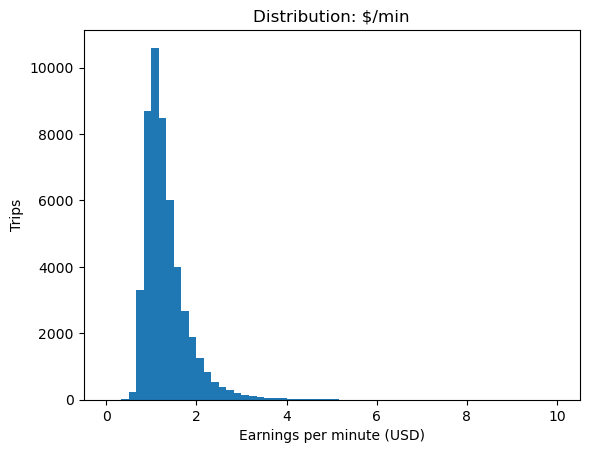

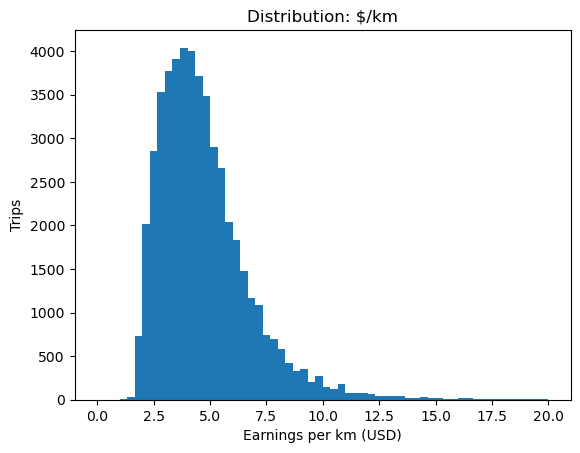

In [19]:
# sample for plotting (keeps it quick)
import numpy as np
from pyspark.sql import functions as F

pdf = (
    df3
    .filter((F.col("earnings_per_min") >= 0) & (F.col("earnings_per_min") <= 10))
    .filter((F.col("earnings_per_km")  >= 0) & (F.col("earnings_per_km")  <= 20))
    .select("earnings_per_min","earnings_per_km","trip_distance")
    .sample(False, 0.01, seed=42)   # 1%
    .limit(50000)                   # hard cap, keeps it snappy
    .toPandas()
)

# drop inf/nan just in case
pdf = pdf.replace([np.inf, -np.inf], np.nan).dropna()

import matplotlib.pyplot as plt

# $/min
plt.hist(pdf["earnings_per_min"], bins=60, range=(0,10))
plt.xlabel("Earnings per minute (USD)")
plt.ylabel("Trips")
plt.title("Distribution: $/min")
plt.show()

# $/km
plt.hist(pdf["earnings_per_km"], bins=60, range=(0,20))
plt.xlabel("Earnings per km (USD)")
plt.ylabel("Trips")
plt.title("Distribution: $/km")
plt.show()

In [21]:
# add columns pickup_hour and pick_dow

df3 = (
    df3
    .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))           
    .withColumn("pickup_dow",  F.date_format("tpep_pickup_datetime","E"))
)

In [75]:
## bring in external dataset, which is gonna be the daily NYC weather (Central Park NOAA station, 2019)

import os
from pyspark.sql import functions as F

weather_csv = os.path.expanduser("~/Documents/GitHub/MAST30034_Python/data/nyc_2019_weather.csv")

weather = (spark.read.csv(weather_csv, header=True, inferSchema=True)
           .withColumn("date", F.to_date("DATE"))   # standardize date format
           .select("date", "TMAX", "TMIN", "PRCP", "AWND"))

# add pickup_date to trips
df3 = df3.withColumn("pickup_date", F.to_date("tpep_pickup_datetime"))

# join trips with weather by date
df_weather = df3.join(weather, df3.pickup_date == weather.date, "left")

# quick peek at merged taxi+weather data
df_weather.select("tpep_pickup_datetime", "trip_distance", "total_amount",
                  "pickup_date", "TMAX", "TMIN", "PRCP", "AWND").show(5, truncate=False)

+--------------------+-------------+------------+-----------+----+----+----+----+
|tpep_pickup_datetime|trip_distance|total_amount|pickup_date|TMAX|TMIN|PRCP|AWND|
+--------------------+-------------+------------+-----------+----+----+----+----+
|2019-01-01 00:46:40 |1.5          |9.95        |2019-01-01 |14.4|3.9 |1.5 |NULL|
|2019-01-01 00:59:47 |2.6          |16.3        |2019-01-01 |14.4|3.9 |1.5 |NULL|
|2019-01-01 00:21:28 |1.3          |9.05        |2019-01-01 |14.4|3.9 |1.5 |NULL|
|2019-01-01 00:32:01 |3.7          |18.5        |2019-01-01 |14.4|3.9 |1.5 |NULL|
|2019-01-01 00:57:32 |2.1          |13.0        |2019-01-01 |14.4|3.9 |1.5 |NULL|
+--------------------+-------------+------------+-----------+----+----+----+----+
only showing top 5 rows


In [31]:
# earnings by hour of day

by_hour = (
    df3.groupBy("pickup_hour")
       .agg(
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min"),
           F.expr("percentile_approx(earnings_per_min, 0.1)").alias("p10"),
           F.expr("percentile_approx(earnings_per_min, 0.9)").alias("p90"),
           F.count("*").alias("trips")
       )
       .orderBy("pickup_hour")
)
by_hour.show(24, truncate=False)

+-----------+------------------+------------------+------------------+-------+
|pickup_hour|p50_$per_min      |p10               |p90               |trips  |
+-----------+------------------+------------------+------------------+-------+
|0          |1.517578125       |1.0764119601328905|2.465619742007852 |1274502|
|1          |1.5614457831325301|1.1164972634870993|2.531645569620253 |882690 |
|2          |1.5844660194174756|1.1416309012875536|2.5670103092783507|611114 |
|3          |1.613793103448276 |1.1541984732824428|2.648936170212766 |433905 |
|4          |1.692821368948247 |1.168986083499006 |2.823529411764706 |338688 |
|5          |1.8537313432835818|1.2427184466019416|2.9820359281437128|404696 |
|6          |1.6334801762114537|1.125             |2.658064516129032 |941819 |
|7          |1.4090121317157713|0.9773195876288661|2.338007380073801 |1638262|
|8          |1.2747747747747749|0.8973637961335678|2.1710526315789473|2034938|
|9          |1.2534031413612567|0.873156342182891 |2

In [25]:
# earnings by day of week

by_dow = (
    df3.groupBy("pickup_dow")
       .agg(
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min"),
           F.count("*").alias("trips")
       )
       .orderBy(F.expr("array_position(array('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), pickup_dow)"))
)
by_dow.show(truncate=False)

+----------+------------------+-------+
|pickup_dow|p50_$per_min      |trips  |
+----------+------------------+-------+
|Mon       |1.4042553191489362|5472720|
|Tue       |1.3351648351648353|6306800|
|Wed       |1.3130563798219586|6589202|
|Thu       |1.28526863084922  |6861282|
|Fri       |1.3028846153846154|6794527|
|Sat       |1.3604014598540148|6302436|
|Sun       |1.4572405929304446|5383411|
+----------+------------------+-------+



In [33]:
## here im gonna map some zone ids to human names, join to trips, and then rank all these
## pickup areas by $/min

import os
zones_csv = os.path.expanduser("~/Documents/GitHub/MAST30034_Python/data/taxi_zones/taxi+_zone_lookup.csv")

# read the TLC zone lookup
zones = (spark.read.csv(zones_csv, header=True)
              .select(F.col("LocationID").cast("int").alias("LocationID"),
                      "Borough","Zone"))
# build two tables, for pickup and for dropoff
pu = zones.select(F.col("LocationID").alias("PULocationID"),
                  F.col("Borough").alias("PUBorough"),
                  F.col("Zone").alias("PUZone"))
do = zones.select(F.col("LocationID").alias("DOLocationID"),
                  F.col("Borough").alias("DOBorough"),
                  F.col("Zone").alias("DOZone"))

# attach human-readable zones to every trip
dfz = df3.join(pu, "PULocationID", "left").join(do, "DOLocationID", "left")

# rank these pickup locations by median earnings per minute
top_pu = (
    dfz.groupBy("PUBorough","PUZone")
       .agg(
           F.count("*").alias("trips"),
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min")
       )
       .filter("trips >= 2000")     # avoid sample that are too tiny
       .orderBy(F.desc("p50_$per_min"))
)
top_pu.show(20, truncate=False)

+---------+----------------------------+-------+------------------+
|PUBorough|PUZone                      |trips  |p50_$per_min      |
+---------+----------------------------+-------+------------------+
|Queens   |Flushing Meadows-Corona Park|7280   |2.4203612479474548|
|Manhattan|Randalls Island             |3095   |1.9378342832091189|
|Queens   |Maspeth                     |3189   |1.881145584725537 |
|Manhattan|Yorkville West              |816867 |1.5579831932773107|
|Queens   |South Jamaica               |6830   |1.5417509591907919|
|Queens   |Briarwood/Jamaica Hills     |5800   |1.5357142857142858|
|Queens   |Corona                      |3632   |1.5263157894736843|
|Queens   |Baisley Park                |16157  |1.5023236852833266|
|Queens   |East Elmhurst               |14312  |1.489539748953975 |
|Queens   |JFK Airport                 |1248879|1.4829778672032194|
|Queens   |Jamaica                     |8039   |1.4758597662771287|
|Manhattan|Upper West Side South       |1142065|

In [35]:
# bucket the trips by distance and see how the median $/min changes, with respect to trip length

dist_bins = (
    df3.select(
        F.when(F.col("trip_distance")<1, "0–1")
         .when(F.col("trip_distance")<3, "1–3")
         .when(F.col("trip_distance")<5, "3–5")
         .when(F.col("trip_distance")<10,"5–10")
         .otherwise("10+").alias("dist_bin"),
        "earnings_per_min"
    )
    .groupBy("dist_bin")
    .agg(
        F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50_$per_min"),
        F.count("*").alias("trips")
    )
    .orderBy("dist_bin")
)
dist_bins.show(truncate=False)

+--------+------------------+--------+
|dist_bin|p50_$per_min      |trips   |
+--------+------------------+--------+
|0–1     |1.8383458646616542|10648548|
|10+     |1.4721900347624566|2778439 |
|1–3     |1.2633262260127933|21702520|
|3–5     |1.1222493887530562|4880587 |
|5–10    |1.2738939816660024|3700284 |
+--------+------------------+--------+



In [37]:
## so im gonna cache this cleaned dataset so i dont have to recompute it next time

import os

clean_parquet = os.path.expanduser(
    "~/Documents/GitHub/MAST30034_Python/data/tute_data/df3_clean.parquet"
)

# make sure the parent folder exists
os.makedirs(os.path.dirname(clean_parquet), exist_ok=True)

# then overwrite to make sure that old cache is always replaced
df3.write.mode("overwrite").parquet(clean_parquet)

print("saved to: " + clean_parquet + "innit")

saved to: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/data/tute_data/df3_clean.parquet


In [39]:
## Earnings vs Time, I did sm time-based performance summaries

# performance by hour of day
by_hour = (
    df3.groupBy("pickup_hour")
       .agg(
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min"),
           F.expr("percentile_approx(earnings_per_min, 0.1)").alias("p10"),
           F.expr("percentile_approx(earnings_per_min, 0.9)").alias("p90"),
           F.count("*").alias("trips")
       )
       .orderBy("pickup_hour")
)

# performance by day of week
by_dow = (
    df3.groupBy("pickup_dow")
       .agg(
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min"),
           F.count("*").alias("trips")
       )
       .orderBy(F.expr("array_position(array('Mon','Tue','Wed','Thu','Fri','Sat','Sun'), pickup_dow)"))
)

by_hour.show(24, truncate=False)
by_dow.show(truncate=False)

+-----------+------------------+------------------+------------------+-------+
|pickup_hour|p50_$per_min      |p10               |p90               |trips  |
+-----------+------------------+------------------+------------------+-------+
|0          |1.517578125       |1.0764119601328905|2.465619742007852 |1274502|
|1          |1.5614457831325301|1.1164972634870993|2.531645569620253 |882690 |
|2          |1.5844660194174756|1.1416309012875536|2.5670103092783507|611114 |
|3          |1.613793103448276 |1.1541984732824428|2.648936170212766 |433905 |
|4          |1.692821368948247 |1.168986083499006 |2.823529411764706 |338688 |
|5          |1.8537313432835818|1.2427184466019416|2.9820359281437128|404696 |
|6          |1.6334801762114537|1.125             |2.658064516129032 |941819 |
|7          |1.4090121317157713|0.9773195876288661|2.338007380073801 |1638262|
|8          |1.2747747747747749|0.8973637961335678|2.1710526315789473|2034938|
|9          |1.2534031413612567|0.873156342182891 |2

+----------+------------------+-------+
|pickup_dow|p50_$per_min      |trips  |
+----------+------------------+-------+
|Mon       |1.4042553191489362|5472720|
|Tue       |1.3351648351648353|6306800|
|Wed       |1.3130563798219586|6589202|
|Thu       |1.28526863084922  |6861282|
|Fri       |1.3028846153846154|6794527|
|Sat       |1.3604014598540148|6302436|
|Sun       |1.4572405929304446|5383411|
+----------+------------------+-------+



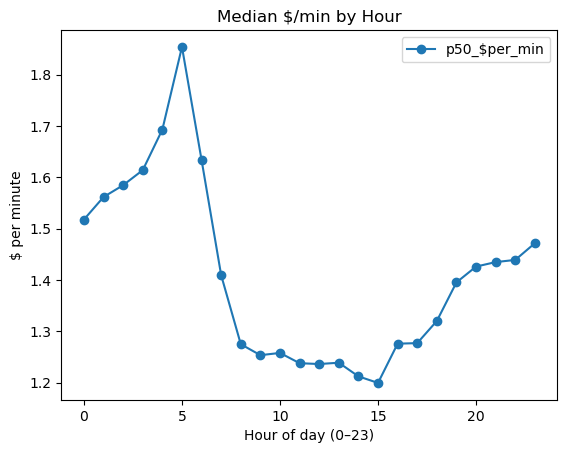

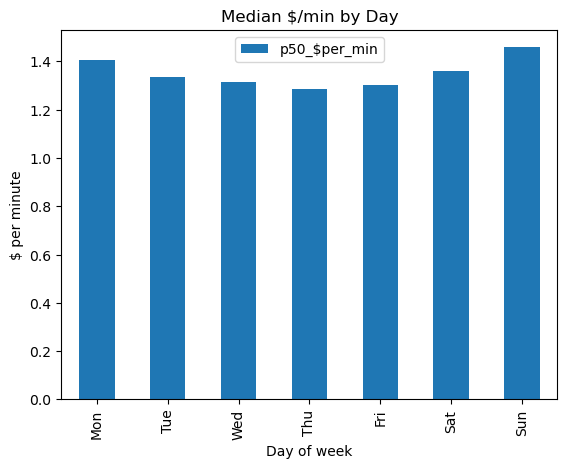

In [41]:
## graph the above earnings vs time

bh = by_hour.toPandas()
bd = by_dow.toPandas()

import matplotlib.pyplot as plt

bh.plot(x="pickup_hour", y="p50_$per_min", kind="line", marker="o")
plt.title("Median $/min by Hour"); plt.ylabel("$ per minute"); plt.xlabel("Hour of day (0–23)"); plt.show()

bd.plot(x="pickup_dow", y="p50_$per_min", kind="bar")
plt.title("Median $/min by Day"); plt.ylabel("$ per minute"); plt.xlabel("Day of week"); plt.show()

In [45]:
## Get the best areas for pickup

import os
zones_csv = os.path.expanduser(
    "~/Documents/GitHub/MAST30034_Python/data/taxi_zones/taxi+_zone_lookup.csv"
)

zones = (
    spark.read.csv(zones_csv, header=True)
         .select(
             F.col("LocationID").cast("int").alias("LocationID"),
             "Borough",
             "Zone"
         )
)

# gotta rename the columns so they line up with trip schema for pidkups
pu = zones.select(
    F.col("LocationID").alias("PULocationID"),
    F.col("Borough").alias("PUBorough"),
    F.col("Zone").alias("PUZone")
)

# add pickup zone names onto trips
dfz = df3.join(pu, "PULocationID", "left")

# rank pickup zones by median earnings/min (and show trip volume)
top_pu = (
    dfz.groupBy("PUBorough", "PUZone")
       .agg(
           F.count("*").alias("trips"),
           F.expr("percentile_approx(earnings_per_min, 0.5)").alias("p50_$per_min")
       )
       .filter("trips >= 2000") 
       .orderBy(F.desc("p50_$per_min"))    
)

top_pu.show(20, truncate=False)

+---------+----------------------------+-------+------------------+
|PUBorough|PUZone                      |trips  |p50_$per_min      |
+---------+----------------------------+-------+------------------+
|Queens   |Flushing Meadows-Corona Park|7280   |2.4203612479474548|
|Manhattan|Randalls Island             |3095   |1.9378342832091189|
|Queens   |Maspeth                     |3189   |1.881145584725537 |
|Manhattan|Yorkville West              |816867 |1.5579831932773107|
|Queens   |South Jamaica               |6830   |1.5417509591907919|
|Queens   |Briarwood/Jamaica Hills     |5800   |1.5357142857142858|
|Queens   |Corona                      |3632   |1.5263157894736843|
|Queens   |Baisley Park                |16157  |1.5023236852833266|
|Queens   |East Elmhurst               |14312  |1.489539748953975 |
|Queens   |JFK Airport                 |1248879|1.4829778672032194|
|Queens   |Jamaica                     |8039   |1.4758597662771287|
|Manhattan|Upper West Side South       |1142065|

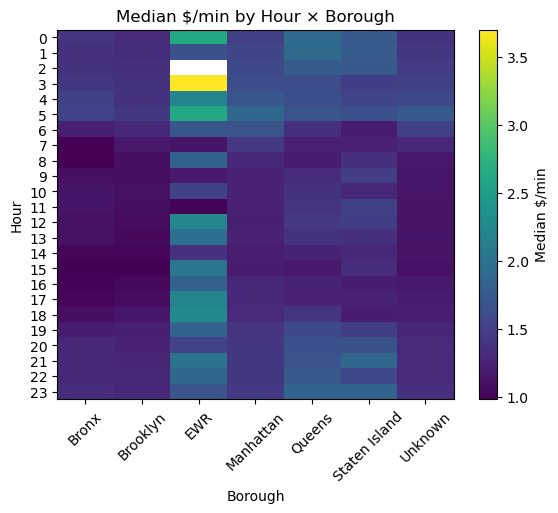

In [47]:
## hour x borough heatmap

hour_boro = (
    dfz.groupBy("pickup_hour","PUBorough")
       .agg(F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50"))
)

# each borough would be its own column
pdf_hb = (
    hour_boro.toPandas()
             .pivot(index="pickup_hour", columns="PUBorough", values="p50")
             .sort_index()
)

import matplotlib.pyplot as plt
plt.imshow(pdf_hb, aspect="auto")   # simple heatmap
plt.xticks(range(len(pdf_hb.columns)), pdf_hb.columns, rotation=45)
plt.yticks(range(len(pdf_hb.index)), pdf_hb.index)
plt.colorbar(label="Median $/min")
plt.title("Median $/min by Hour × Borough")
plt.xlabel("Borough"); plt.ylabel("Hour")
plt.show()

In [49]:
# distance sweeet spots

dist_bins = (
    df3.select(
        F.when(F.col("trip_distance")<1, "0–1")
         .when(F.col("trip_distance")<3, "1–3")
         .when(F.col("trip_distance")<5, "3–5")
         .when(F.col("trip_distance")<10,"5–10")
         .otherwise("10+").alias("dist_bin"),
        "earnings_per_min"
    )
    .groupBy("dist_bin")
    .agg(F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50_$per_min"),
         F.count("*").alias("trips"))
    .orderBy("dist_bin")
)
dist_bins.show(truncate=False)

+--------+------------------+--------+
|dist_bin|p50_$per_min      |trips   |
+--------+------------------+--------+
|0–1     |1.8383458646616542|10648548|
|10+     |1.4721900347624566|2778439 |
|1–3     |1.2633262260127933|21702520|
|3–5     |1.1222493887530562|4880587 |
|5–10    |1.2738939816660024|3700284 |
+--------+------------------+--------+



In [53]:
# gonna save these for later so i don't have to recompute them

import os

artefact_dir = os.path.expanduser("~/Documents/GitHub/MAST30034_Python/data/tute_data")


df3.write.mode("overwrite").parquet(os.path.join(artefact_dir, "df3_clean.parquet"))
by_hour.write.mode("overwrite").csv(os.path.join(artefact_dir, "by_hour.csv"), header=True)
by_dow.write.mode("overwrite").csv(os.path.join(artefact_dir, "by_dow.csv"), header=True)
top_pu.write.mode("overwrite").csv(os.path.join(artefact_dir, "top_pickup_zones.csv"), header=True)

print("artefacts saved into:", artefact_dir)

artefacts saved into: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/data/tute_data


+-------+------------------+---------+--------+
|is_rain|p50_$per_min      |p50_miles|trips   |
+-------+------------------+---------+--------+
|true   |1.35632183908046  |1.65     |16195806|
|false  |1.34014598540146  |1.66     |27514019|
|NULL   |1.2008059100067159|1.8      |553     |
+-------+------------------+---------+--------+



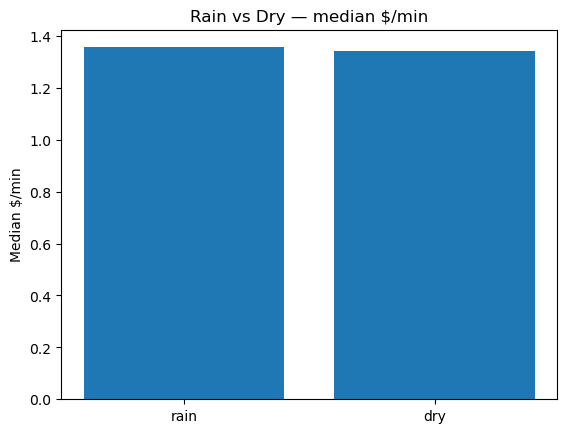

In [77]:
## alright i wanna bring it the NYC weather dataset
## im gonna start by comparing rainy vs dry days

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

dfw = df_weather.withColumn("is_rain", (F.col("PRCP") >= 1.0).cast("boolean"))

rain_vs_dry = (
    dfw.groupBy("is_rain")
       .agg(
           F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50_$per_min"),
           F.expr("percentile_approx(trip_distance,0.5)").alias("p50_miles"),
           F.count("*").alias("trips")
       )
       .orderBy(F.desc("is_rain"))
)

rain_vs_dry.show(truncate=False)

# bar graph is probably best for this, plotting median $/min for rainy vs dry days
pdf_rain = rain_vs_dry.toPandas()
labels = ["rain" if x else "dry" for x in pdf_rain["is_rain"]]
plt.bar(labels, pdf_rain["p50_$per_min"])
plt.ylabel("Median $/min")
plt.title("Rain vs Dry — median $/min")
plt.show()

+--------+------------------+-------+
|temp_bin|p50_$per_min      |trips  |
+--------+------------------+-------+
|<0      |1.27007299270073  |7408039|
|0–5     |1.3399103139013453|7645973|
|5–10    |1.3547038327526133|7396744|
|10–15   |1.3779761904761902|6706952|
|15–20   |1.3678756476683938|7388691|
|20–25   |1.3827814569536425|5986344|
|25+     |1.326241134751773 |1177635|
+--------+------------------+-------+



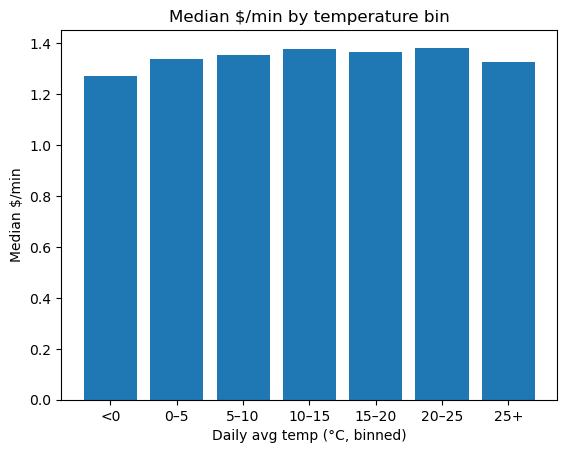

In [79]:
## then i can compare $/min by temperature too

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

dfw_t = df_weather.withColumn("tavg_c", (F.col("TMAX") + F.col("TMIN")) / 2.0)

temp_bins = (
    dfw_t.select(
        F.when(F.col("tavg_c") < 0, "<0")
         .when(F.col("tavg_c") < 5, "0–5")
         .when(F.col("tavg_c") < 10, "5–10")
         .when(F.col("tavg_c") < 15, "10–15")
         .when(F.col("tavg_c") < 20, "15–20")
         .when(F.col("tavg_c") < 25, "20–25")
         .otherwise("25+").alias("temp_bin"),
        "earnings_per_min"
    )
    .groupBy("temp_bin")
    .agg(
        F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50_$per_min"),
        F.count("*").alias("trips")
    )
)

# just to make the bins in order
order = ["<0","0–5","5–10","10–15","15–20","20–25","25+"]
temp_bins = (temp_bins
    .withColumn("ord", F.array_position(F.array([F.lit(x) for x in order]), F.col("temp_bin")))
    .orderBy("ord")
    .drop("ord")
)

temp_bins.show(truncate=False)

# again bar plot is best
pdf_tmp = temp_bins.toPandas()
plt.bar(pdf_tmp["temp_bin"], pdf_tmp["p50_$per_min"])
plt.xlabel("Daily avg temp (°C, binned)")
plt.ylabel("Median $/min")
plt.title("Median $/min by temperature bin")
plt.show()

In [81]:
## light vs medium vs heavy rain

rb = (
    df_weather.select(
        F.when(F.col("PRCP") < 1.0, "0–1mm")
         .when(F.col("PRCP") < 5.0, "1–5mm")
         .when(F.col("PRCP") < 15.0, "5–15mm")
         .otherwise("15mm+").alias("rain_bin"),
        "earnings_per_min"
    )
    .groupBy("rain_bin")
    .agg(F.expr("percentile_approx(earnings_per_min,0.5)").alias("p50_$per_min"),
         F.count("*").alias("trips"))
    .orderBy("rain_bin")
)
rb.show(truncate=False)

+--------+------------------+--------+
|rain_bin|p50_$per_min      |trips   |
+--------+------------------+--------+
|0–1mm   |1.34014598540146  |27514019|
|15mm+   |1.349736379613357 |4553453 |
|1–5mm   |1.3571428571428572|6374488 |
|5–15mm  |1.3611940298507463|5268418 |
+--------+------------------+--------+



In [85]:
## okay now lets finish off with some ML, some deeper analysis before I get into report
## here im gonna predict trip efficiency ($/min) using certain trip features and the weather,
## using a linear regression model

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# keep the useful fields and drop NAs
ml_df = df_weather.select(
    "earnings_per_min", "trip_distance", "duration_min", "TMAX", "TMIN", "PRCP"
).dropna()

feature_cols = ["trip_distance","duration_min","TMAX","TMIN","PRCP"]

# assemble these features into vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# build a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="earnings_per_min")

# pipeline = assembler + regression
pipeline = Pipeline(stages=[assembler, lr])

# fit the model
model = pipeline.fit(ml_df)

# get some summary stats
lr_model = model.stages[-1]
print("✅ Regression model trained")
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("R^2:", lr_model.summary.r2)
print("RMSE:", lr_model.summary.rootMeanSquaredError)

# just have a look at some predictions
preds = model.transform(ml_df).select("earnings_per_min","prediction","trip_distance","duration_min","PRCP")
preds.show(10, truncate=False)

25/08/31 17:21:26 WARN Instrumentation: [1714b9c6] regParam is zero, which might cause numerical instability and overfitting.
25/08/31 17:21:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/08/31 17:21:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✅ Regression model trained
Coefficients: [0.11884897037673561,-0.056538439248212516,0.0015110851434466076,0.005753686512998171,0.00035847081830377847]
Intercept: 1.909049457919135
R^2: 0.3614413441204435
RMSE: 0.5222481352408325
+------------------+-------------------+-------------+------------------+----+
|earnings_per_min  |prediction         |trip_distance|duration_min      |PRCP|
+------------------+-------------------+-------------+------------------+----+
|1.4925            |1.7551366948566014 |1.5          |6.666666666666667 |1.5 |
|0.8489583333333334|1.1772554570267468 |2.6          |19.2              |1.5 |
|1.2657342657342658|1.7040399884779516 |1.3          |7.15              |1.5 |
|1.3569682151589242|1.6227199695895393 |3.7          |13.633333333333333|1.5 |
|1.0833333333333333|1.5249077344255093 |2.1          |12.0              |1.5 |
|0.8487698986975397|0.9842945673172794 |2.8          |23.033333333333335|1.5 |
|1.3246753246753247|1.674192128367266  |0.7          |6.4166

In [89]:
## then i can use logistic regression to classify high-efficieny trips

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# output 1 if $/min >= median, otherwise 0
median_epm = df_weather.approxQuantile("earnings_per_min", [0.5], 0.01)[0]
clf_df = (
    df_weather
      .withColumn("label", (F.col("earnings_per_min") >= F.lit(median_epm)).cast("int"))
      # simple engineered features
      .withColumn("rain_flag", (F.col("PRCP") > 0.1).cast("int"))                 
      .withColumn("tavg", (F.col("TMAX") + F.col("TMIN"))/2.0)                    
      .select("label","trip_distance","duration_min","tavg","PRCP","rain_flag","pickup_hour")
      .dropna()
)

# assemble the features
feat_cols = ["trip_distance","duration_min","tavg","PRCP","rain_flag","pickup_hour"]
assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")

# model
logr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=50)

pipe = Pipeline(stages=[assembler, logr])

# conduct a train/testing split
train_df, test_df = clf_df.randomSplit([0.8, 0.2], seed=42)
clf_model = pipe.fit(train_df)

# then evaluate innit
pred = clf_model.transform(test_df)

auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(pred)
acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(pred)

print(f"Logistic Regression trained. AUC = {auc:.3f} | Accuracy = {acc:.3f}")

# have a look at the coefficients (thats important)
lr_stage = clf_model.stages[-1]
for name, coef in zip(feat_cols, lr_stage.coefficients):
    print(f"{name:15s}  coef = {coef:+.4f}")
print("Intercept:", lr_stage.intercept)

# and sus a few of the predictions
pred.select("label","prediction","probability","trip_distance","duration_min","PRCP","pickup_hour").show(10, truncate=False)

25/08/31 17:36:33 WARN MemoryStore: Not enough space to cache rdd_728_1 in memory! (computed 113.0 MiB so far)
25/08/31 17:36:33 WARN BlockManager: Persisting block rdd_728_1 to disk instead.
25/08/31 17:36:34 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 113.0 MiB so far)
25/08/31 17:36:34 WARN BlockManager: Persisting block rdd_728_0 to disk instead.
25/08/31 17:36:34 WARN MemoryStore: Not enough space to cache rdd_728_2 in memory! (computed 113.0 MiB so far)
25/08/31 17:36:34 WARN BlockManager: Persisting block rdd_728_2 to disk instead.
25/08/31 17:36:35 WARN MemoryStore: Not enough space to cache rdd_728_3 in memory! (computed 177.0 MiB so far)
25/08/31 17:36:35 WARN BlockManager: Persisting block rdd_728_3 to disk instead.
25/08/31 17:36:39 WARN MemoryStore: Not enough space to cache rdd_728_4 in memory! (computed 272.8 MiB so far)
25/08/31 17:36:39 WARN BlockManager: Persisting block rdd_728_4 to disk instead.
25/08/31 17:36:40 WARN MemoryStore: Not 

[20419.774s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 275.0 (TID 1073): Retried waiting for GCLocker too often allocating 4194306 words
[20419.783s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 275.0 (TID 1073): Retried waiting for GCLocker too often allocating 4194306 words
[20419.789s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 275.0 (TID 1073): Retried waiting for GCLocker too often allocating 4194306 words
[20419.793s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 275.0 (TID 1073): Retried waiting for GCLocker too often allocating 4194306 words
[20419.797s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 275.0 (TID 1073): Retried waiting for GCLocker too often allocating 4194306 words


25/08/31 17:36:54 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/08/31 17:36:54 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/08/31 17:36:54 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/08/31 17:36:54 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.
25/08/31 17:36:54 WARN TaskMemoryManager: Failed to allocate a page (33554432 bytes), try again.


Logistic Regression trained. AUC = 0.941 | Accuracy = 0.865
trip_distance    coef = +1.7216
duration_min     coef = -0.7240
tavg             coef = +0.0507
PRCP             coef = -0.0025
rain_flag        coef = +0.0852
pickup_hour      coef = +0.0272
Intercept: 3.6335292452867876


+-----+----------+----------------------------------------+-------------+------------------+----+-----------+
|label|prediction|probability                             |trip_distance|duration_min      |PRCP|pickup_hour|
+-----+----------+----------------------------------------+-------------+------------------+----+-----------+
|0    |1.0       |[0.22549770230719637,0.7745022976928037]|0.13         |4.7               |33.8|13         |
|0    |1.0       |[0.15836089416992666,0.8416391058300734]|0.14         |3.95              |7.4 |19         |
|0    |1.0       |[0.16502791759441834,0.8349720824055816]|0.15         |3.5833333333333335|0.0 |17         |
|0    |1.0       |[0.1178169679568408,0.8821830320431592] |0.15         |3.8               |1.5 |12         |
|0    |1.0       |[0.08295500760257449,0.9170449923974255]|0.16         |2.783333333333333 |0.0 |13         |
|0    |1.0       |[0.16085822294333585,0.8391417770566642]|0.16         |3.6333333333333333|0.0 |11         |
|0    |1.0

In [91]:
print("Raw rows:", df.count())
print("After cleaning:", df2.count())
print("After trimming:", df3.count())
print("After weather join:", df_weather.count())

Raw rows: 44658561
After cleaning: 44270689


After trimming: 43710378


After weather join: 43710378


In [101]:
# alright wait so for the report im gonna just export figures here

import matplotlib.pyplot as plt
import pandas as pd
import os

fig_dir = os.path.expanduser("~/Documents/GitHub/MAST30034_Python/figures")
os.makedirs(fig_dir, exist_ok=True)

# Figure 1 - the summary stats table
summary_trim.toPandas().to_csv(os.path.join(fig_dir, "fig1_summary_stats.csv"), index=False)

# figure 2: Histogram $/min
plt.hist(pdf["earnings_per_min"], bins=60, range=(0,10))
plt.xlabel("Earnings per minute (USD)"); plt.ylabel("Trips")
plt.title("Distribution: $/min")
plt.savefig(os.path.join(fig_dir, "fig2_hist_epm.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 3: Histogram $/km
plt.hist(pdf["earnings_per_km"], bins=60, range=(0,20))
plt.xlabel("Earnings per km (USD)"); plt.ylabel("Trips")
plt.title("Distribution: $/km")
plt.savefig(os.path.join(fig_dir, "fig3_hist_epkm.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 4: Line plot median $/min by hour
bh = by_hour.toPandas()
bh.plot(x="pickup_hour", y="p50_$per_min", kind="line", marker="o")
plt.title("Median $/min by Hour"); plt.ylabel("$ per minute"); plt.xlabel("Hour of day (0–23)")
plt.savefig(os.path.join(fig_dir, "fig4_by_hour.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 5: Bar chart median $/min by day
bd = by_dow.toPandas()
bd.plot(x="pickup_dow", y="p50_$per_min", kind="bar")
plt.title("Median $/min by Day"); plt.ylabel("$ per minute"); plt.xlabel("Day of week")
plt.savefig(os.path.join(fig_dir, "fig5_by_dow.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 6: Top pickup zones table
top_pu.toPandas().to_csv(os.path.join(fig_dir, "fig6_top_pickup_zones.csv"), index=False)

# figure 7 - Heatmap (hour × borough)
pdf_hb = hour_boro.toPandas().pivot(index="pickup_hour", columns="PUBorough", values="p50").sort_index()
plt.imshow(pdf_hb, aspect="auto")
plt.xticks(range(len(pdf_hb.columns)), pdf_hb.columns, rotation=45)
plt.yticks(range(len(pdf_hb.index)), pdf_hb.index)
plt.colorbar(label="Median $/min")
plt.title("Median $/min by Hour × Borough")
plt.xlabel("Borough"); plt.ylabel("Hour")
plt.savefig(os.path.join(fig_dir, "fig7_heatmap_hour_boro.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 8: Distance bin table
dist_bins.toPandas().to_csv(os.path.join(fig_dir, "fig8_distance_bins.csv"), index=False)

# figure 9: Rain vs Dry bar chart
pdf_rain = rain_vs_dry.toPandas()
labels = ["rain" if x else "dry" for x in pdf_rain["is_rain"]]
plt.bar(labels, pdf_rain["p50_$per_min"])
plt.ylabel("Median $/min"); plt.title("Rain vs Dry — median $/min")
plt.savefig(os.path.join(fig_dir, "fig9_rain_vs_dry.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 10: Temperature bin bar chart
pdf_tmp = temp_bins.toPandas()
plt.bar(pdf_tmp["temp_bin"], pdf_tmp["p50_$per_min"])
plt.xlabel("Daily avg temp (°C, binned)"); plt.ylabel("Median $/min")
plt.title("Median $/min by temperature bin")
plt.savefig(os.path.join(fig_dir, "fig10_temp_bins.png"), dpi=300, bbox_inches="tight")
plt.close()

# figure 11: Rain bin table
rb.toPandas().to_csv(os.path.join(fig_dir, "fig11_rain_bins.csv"), index=False)

# omg

print("these figures and tables saved into:", fig_dir)

these figures and tables saved into: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/figures


In [105]:
import os, glob
import pandas as pd

# 1) Where your figures/CSVs were exported
repo_root  = os.path.expanduser("~/Documents/GitHub/MAST30034_Python")
plots_dir  = os.path.join(repo_root, "plots")

# Try the obvious paths first, then fall back to a recursive search
candidates = [
    os.path.join("fig6_top_pickup_zones.csv"),
    os.path.join(plots_dir, "fig6_top_pickup_zones.csv"),
]
csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    hits = glob.glob(os.path.join(repo_root, "**", "fig6_top_pickup_zones.csv"), recursive=True)
    if not hits:
        raise FileNotFoundError("Couldn't find fig6_top_pickup_zones.csv. Check where you saved your exports.")
    csv_path = hits[0]

print("Reading:", csv_path)
df_zones = pd.read_csv(csv_path)

# 2) Keep only the columns we need; sort by trips desc; top 10
keep_cols = ["PUBorough", "PUZone", "trips", "p50_$per_min"]
missing = [c for c in keep_cols if c not in df_zones.columns]
if missing:
    raise ValueError(f"Expected columns missing: {missing}\nGot columns: {list(df_zones.columns)}")

df_top10 = (
    df_zones[keep_cols]
    .sort_values("trips", ascending=False)
    .head(10)
    .copy()
)

# Neaten numbers
df_top10["trips"] = df_top10["trips"].astype(int)
df_top10["p50_$per_min"] = df_top10["p50_$per_min"].round(2)

# 3) Save next to the other figures
out_csv = os.path.join(plots_dir, "fig6_top10_pickup_zones.csv")
os.makedirs(plots_dir, exist_ok=True)
df_top10.to_csv(out_csv, index=False)
print("Saved:", out_csv)
df_top10

Reading: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/figures/fig6_top_pickup_zones.csv
Saved: /Users/habibhaadi/Documents/GitHub/MAST30034_Python/plots/fig6_top10_pickup_zones.csv


,PUBorough,PUZone,trips,p50_$per_min
20,Manhattan,Upper East Side South,1881081,1.41
73,Manhattan,Midtown Center,1792252,1.26
17,Manhattan,Upper East Side North,1732869,1.44
49,Manhattan,Midtown East,1582225,1.32
111,Manhattan,Penn Station/Madison Sq West,1520671,1.19
63,Manhattan,Times Sq/Theatre District,1485494,1.29
27,Manhattan,Clinton East,1390158,1.39
48,Manhattan,Murray Hill,1350765,1.33
56,Manhattan,Union Sq,1340739,1.30
29,Manhattan,Lincoln Square East,1323067,1.38


In [111]:
import pandas as pd
import os

# Path to your figures folder
fig_dir = os.path.expanduser("~/Documents/GitHub/MAST30034_Python/figures")

# Load the full pickup zones table
df_zones = pd.read_csv(os.path.join(fig_dir, "fig6_top_pickup_zones.csv"))

# Sort by median $/min and keep top 10
df_top10_medians = df_zones.sort_values("p50_$per_min", ascending=False).head(10)

# Save as a new CSV in the same figures folder
out_path = os.path.join(fig_dir, "fig6_top10_median_pickup_zones.csv")
df_top10_medians.to_csv(out_path, index=False)

print(f"Saved Top 10 zones by median $/min → {out_path}")
print(df_top10_medians)

Saved Top 10 zones by median $/min → /Users/habibhaadi/Documents/GitHub/MAST30034_Python/figures/fig6_top10_median_pickup_zones.csv
   PUBorough                        PUZone    trips  p50_$per_min
0     Queens  Flushing Meadows-Corona Park     7280      2.420361
1  Manhattan               Randalls Island     3095      1.937834
2     Queens                       Maspeth     3189      1.881146
3  Manhattan                Yorkville West   816867      1.557983
4     Queens                 South Jamaica     6830      1.541751
5     Queens       Briarwood/Jamaica Hills     5800      1.535714
6     Queens                        Corona     3632      1.526316
7     Queens                  Baisley Park    16157      1.502324
8     Queens                 East Elmhurst    14312      1.489540
9     Queens                   JFK Airport  1248879      1.482978
